In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import openpyxl
from datetime import datetime

In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [3]:
from dqn import DQN
from environment import LunarLanderEnvManager

In [4]:
# EXPERIENCE CLASS

Experience = namedtuple('Experience', ['state', 'action', 'next_state', 'reward', 'done'])

In [5]:
# REPLAY MEMORY CLASS

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [6]:
# EPSILON GREEDY STRATEGY CLASS

class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

In [7]:
# AGENT CLASS

class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device)
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device)

In [8]:
# TRAINING PERFORMANCE PLOTS

def plot(rewards_per_episode, moving_average, losses):
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.title('Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_per_episode)
    plt.plot(moving_average)

    plt.subplot(1,2,2)
    plt.title('Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.plot(losses)
    plt.pause(0.001)
    
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [9]:
# TENSOR PROCESSING FUNCTION

def extract_tensors(expriences):
    batch = Experience(*zip(*experiences))
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    t5 = torch.cat(batch.done)
    return (t1, t2, t3, t4, t5)

In [10]:
# Q-VALUE CALCULATOR CLASS

class QValues():
    device = torch.device("cuda")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        return target_net(next_states).max(dim=1)[0]
    
    @staticmethod
    def get_next_ddqn(policy_net, target_net, next_states):
        with torch.no_grad():
            actions = policy_net(next_states).argmax(dim=1)
        return target_net(next_states).gather(dim=1, index=actions.unsqueeze(-1)).flatten()

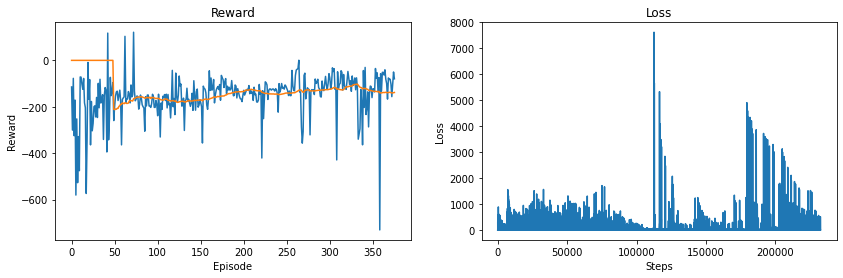

Episode 376
Average: -138.38733
Steps 999


In [ ]:
# MAIN PROGRAM

# SETTINGS
num_episodes = 1000
render = False
double_dqn = False

# HYPERPARAMETERS

batch_size = 32
gamma = 0.99
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 500
memory_size = 50000
lr = 0.001

# OBJECT INSTANCES

device = torch.device("cuda")
em = LunarLanderEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.num_states_available()).to(device)
target_net = DQN(em.num_states_available()).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

rewards_per_episode = []
losses = []

# MAIN LOOP

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    total_reward = 0

    # timestep loop
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        done = em.if_done()
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward, done))
        state = next_state
        total_reward += reward.item()

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states, dones = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            current_q_values = current_q_values.float()

            if double_dqn:
                next_q_values = QValues.get_next_ddqn(policy_net, target_net, next_states)
            else:
                next_q_values = QValues.get_next(target_net, next_states)
            next_q_values = next_q_values.float()

            target_q_values = (next_q_values * gamma) * (1 - dones) + rewards
            target_q_values = target_q_values.float()

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if agent.current_step % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

        if render:
            em.render()

        if em.done:
            rewards_per_episode.append(total_reward)
            moving_average = get_moving_average(50, rewards_per_episode)
            plot(rewards_per_episode, moving_average, losses)
            print("Episode", len(rewards_per_episode))
            print("Average:", moving_average[-1])
            print("Steps", timestep)
            if is_ipython: display.clear_output(wait=True)
            break

        if moving_average[-1] >= 200:
            date_time = datetime.now().strftime("%y%m%d_%H%M%S")
            FILE = "models/model_" + date_time + ".pth"
            torch.save(policy_net.state_dict(), FILE)
            break

em.close()

# workbook = openpyxl.load_workbook('data.xlsx')
# worksheet = workbook['sheet1']

# worksheet.append(moving_average.tolist())
# worksheet.append(rewards_per_episode)

# workbook.save('data.xlsx')